In [1]:
################################################
#### Jingying Wang <astro.jywang@gmail.com> ####
###############################################

#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
#import matplotlib
#matplotlib.use('AGG') #these two lines will make plot that have more details but cannot show in notebook
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
Tcmb=2.725
plot_gsize=90
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb

In [2]:
print 'start @ ' + time.asctime(time.localtime(time.time())) +'...'
t1= time.time()

start @ Sun Mar  1 16:59:55 2020...


In [3]:
print katcali.__version__


0.1.3


# Select an observation block and load basic information in


In [4]:
#select an observation block

#fname='1551037708'  #3c237 [ok]
#fname='1551055211'  #rfi [ok]
#fname='1553966342'  #rfi
fname='1554156377'  #diode noise in one dump ##rfi clean [ok]
#fname='1556138397'  #rfi spots structure
#fname='1555775533'  #vis<1 and structure
#fname='1555793534'  #vis<1 and rfi pollution
#fname='1556120503'  #strong rfi spots in line
#fname='1556052116'  #vis < 10 
#fname='1556034219'  #strong rfi spots in line
#fname='1555879611'  #vis=0 problem
#fname='1555861810'  #vis=0 problem
#fname='1561650779'  #diode shift [ok]
#fname='1558464584'  #3C273 track #diode shift
#fname='1558472940'  #3C273 track #diode shift
#fname='1562857793' #last one, part coverage [ok]

In [5]:
data=kio.load_data(fname)
print data
#print data.obs_script_log

Name: file:///idia/projects/hi_im/SCI-20180330-MS-01/1554156377/1554156377/1554156377_sdp_l0.full.rdb | 1554156377-sdp-l0 (version 4.0)
Observer: MarioSantos  Experiment ID: 20190401-0006
Description: 'constant elevation scan with noise diode pattern'
Observed from 2019-04-02 00:06:25.868 SAST to 2019-04-02 02:11:44.687 SAST
Dump rate / period: 0.50021 Hz / 1.999 s
Subarrays: 1
  ID  Antennas                            Inputs  Corrprods
   0  m000,m001,m002,m003,m004,m005,m006,m007,m008,m009,m010,m011,m012,m013,m015,m016,m018,m019,m020,m021,m022,m023,m024,m025,m026,m027,m028,m029,m030,m031,m033,m034,m035,m037,m038,m039,m040,m041,m042,m043,m044,m045,m046,m047,m048,m049,m050,m051,m052,m053,m054,m055,m056,m057,m058,m059,m060,m061,m062,m063  120      7320
Spectral Windows: 1
  ID Band Product  CentreFreq(MHz)  Bandwidth(MHz)  Channels  ChannelWidth(kHz)
   0 L    c856M4k    1284.000         856.000           4096       208.984
---------------------------------------------------------------

In [6]:
#show the calibrator and bad ants information
target,c0,bad_ants,flux_model=kio.check_ants(fname)


calibrator: 3C273, ra,dec= 187d16m40.4954s, 2d03m08.5979s
bad_ants: ['m014', 'm017', 'm032', 'm036', 'm041', 'm054']


In [7]:
#show ants which have data 
print kio.ant_list(data)

['m000' 'm001' 'm002' 'm003' 'm004' 'm005' 'm006' 'm007' 'm008' 'm009'
 'm010' 'm011' 'm012' 'm013' 'm015' 'm016' 'm018' 'm019' 'm020' 'm021'
 'm022' 'm023' 'm024' 'm025' 'm026' 'm027' 'm028' 'm029' 'm030' 'm031'
 'm033' 'm034' 'm035' 'm037' 'm038' 'm039' 'm040' 'm041' 'm042' 'm043'
 'm044' 'm045' 'm046' 'm047' 'm048' 'm049' 'm050' 'm051' 'm052' 'm053'
 'm054' 'm055' 'm056' 'm057' 'm058' 'm059' 'm060' 'm061' 'm062' 'm063']


# Select ant and polarization, then load data in 

In [8]:
#select ant, polarization, and one channel to show data calibration
ant='m000'
pol='v'
ch_plot=800


In [9]:
#load data, labels, and parameters
data.select(ants=ant,pol=pol)
recv=ant+pol
corr_id=kio.cal_corr_id(data,recv)
assert(recv==data.corr_products[corr_id][0])
assert(recv==data.corr_products[corr_id][1])
print corr_id,recv
vis,flags= kio.call_vis(fname,recv)
vis_backup=vis.copy()
ra,dec,az,el=kio.load_coordinates(data)
timestamps,freqs=kio.load_tf(data)
nd_set,nd_time,nd_cycle,nd_ratio=kio.load_ndparam(fname,data)
dp_tt,dp_ss,dp_f,dp_t,dp_s=kl.label_dump_1ch(data,ant,pol,flags,ch_plot)
dp_w=kl.select_waste(data,ant,pol)
assert(np.shape(data)[2]==1)
dp_sb=dp_ss[0]
dp_se=dp_ss[-1]
ang_deg=kio.load_ang_deg(ra,dec,c0)
p_radec=np.loadtxt('radio_source.txt')

0 m000v
['m000v' 'm000v']


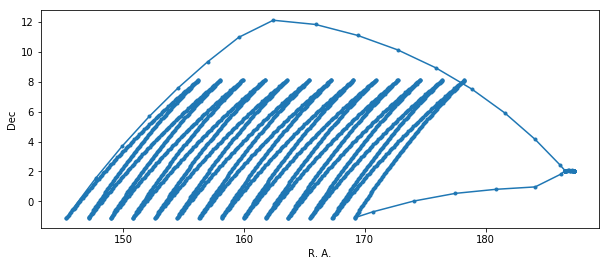

In [10]:
#show the scan route, typically track calibrator + scan sky + track calibrator 
plt.figure(figsize=(10,4))
plt.plot(ra,dec,'.-')
plt.xlabel('R. A.')
plt.ylabel('Dec')
plt.show()

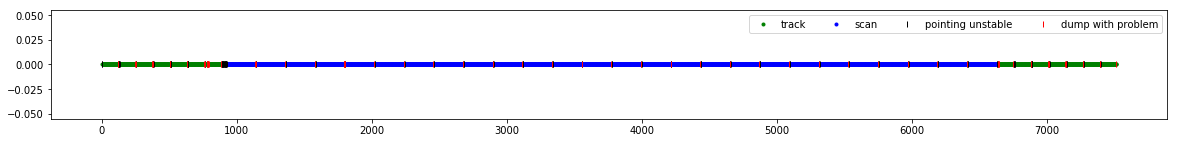

In [11]:
#show time dump label along the scan 
plt.figure(figsize=(20,2))
plt.plot(timestamps[dp_tt]-timestamps[0],np.zeros_like(dp_tt),'g.')
plt.plot(timestamps[dp_ss]-timestamps[0],np.zeros_like(dp_ss),'b.')
plt.plot(timestamps[dp_w]-timestamps[0],np.zeros_like(dp_w),'k|')
plt.plot(timestamps[dp_f]-timestamps[0],np.zeros_like(dp_f),'r|')
plt.legend(['track','scan','pointing unstable','dump with problem'],ncol=4)
plt.show()

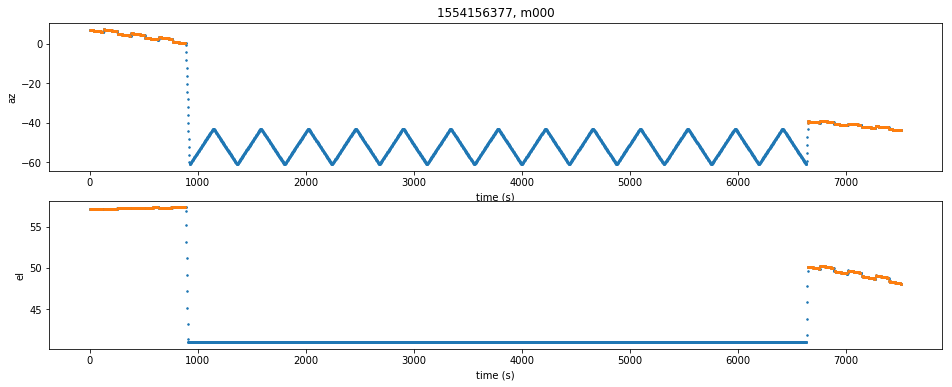

In [12]:
#show the az,el along time
plt.figure(figsize=(16,6))
plt.subplot(211)
if ant not in bad_ants:
    plt.plot(timestamps-timestamps[0],az,'.',Markersize=3)
    plt.plot(timestamps[dp_tt]-timestamps[0],az[dp_tt],'.',Markersize=3)
plt.xlabel('time (s)')
plt.ylabel('az')
plt.title(str(fname)+', '+str(ant))
plt.subplot(212)
if ant not in bad_ants:
    plt.plot(timestamps-timestamps[0],el,'.',Markersize=3)
    plt.plot(timestamps[dp_tt]-timestamps[0],el[dp_tt],'.',Markersize=3)
plt.xlabel('time (s)')
plt.ylabel('el')
#plt.savefig(str(fname)+'_'+str(ant)+'_azel.pdf')
plt.show()

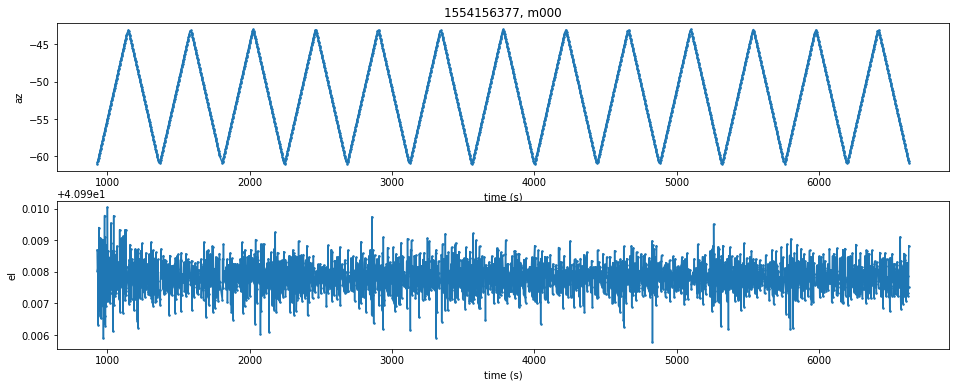

In [13]:
#az,el for scan part, which are expected to be stable
plt.figure(figsize=(16,6))
plt.subplot(211)
if ant not in bad_ants:
    plt.plot(timestamps[dp_ss]-timestamps[0],az[dp_ss],'.-',Markersize=3)
plt.xlabel('time (s)')
plt.ylabel('az')
plt.title(str(fname)+', '+str(ant))
plt.subplot(212)
if ant not in bad_ants:
    plt.plot(timestamps[dp_ss]-timestamps[0],el[dp_ss],'.-',Markersize=3)
plt.xlabel('time (s)')
plt.ylabel('el')
#plt.savefig(str(fname)+'_'+str(ant)+'_azel.pdf')
plt.show()

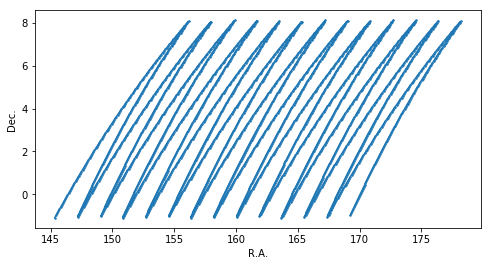

In [14]:
#sky coverage in scan part
plt.figure(figsize=(8,4))
if ant not in bad_ants:
    plt.plot(ra[dp_ss],dec[dp_ss],'.-',Markersize=3)
plt.xlabel('R.A.')
plt.ylabel('Dec.')
plt.show()

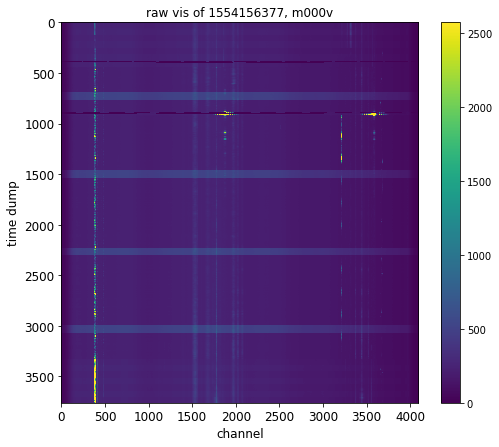

In [15]:
#raw visibility
plt.figure(figsize=(8,7))
plt.imshow(vis,aspect='auto')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('time dump',fontsize=12)
plt.xlabel('channel',fontsize=12)
plt.title('raw vis of '+str(fname)+', '+str(recv),fontsize=12)
plt.colorbar()
#plt.savefig(str(fname)+'_'+str(recv)+'_raw_vis.pdf')
plt.show()

In [16]:
#read noise diode labels in 
t_line=kd.cal_t_line(fname, timestamps,nd_set, nd_cycle, data.dump_period)
#mark,nd_1_det,nd_1a_det,nd_1b_det,lmin,lmax=kd.label_nd_injection(fname,vis, timestamps, dp_ss, data.dump_period)
nd_1a,nd_1b,nd_1,nd_0=kd.call_nd_1_list(fname,timestamps)
nd_s1a,nd_s1b,nd_s1,nd_s0=kd.cal_nds_list(dp_ss,nd_1a,nd_1b,nd_1,nd_0)#dp_ss here, not dp_s
nd_t1a,nd_t1b,nd_t1,nd_t0=kd.cal_ndt_list(dp_tt,nd_1a,nd_1b,nd_1,nd_0)#dp_tt here, not dp_t
nd_labels=nd_s1a,nd_s1b,nd_s1,nd_s0,nd_t1a,nd_t1b,nd_t1,nd_t0
nd_label0=dp_s,dp_t,nd_1a,nd_1b,nd_1,nd_0 ###only for rfi flagging

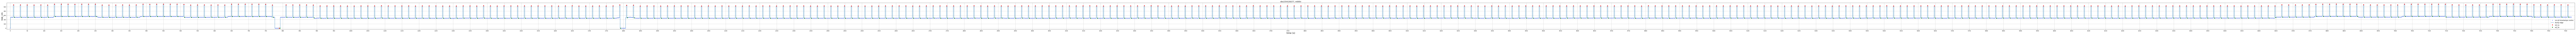

In [17]:
#noise diode injection along time ***plot is very long***
ch_plot0=800
plt.figure(figsize=(np.shape(timestamps)[0]*0.1,4))
plt.plot(timestamps-timestamps[0],(vis[:,ch_plot0]),'b.')
plt.step(timestamps-timestamps[0],(vis[:,ch_plot0]),'-',where='mid')
plt.plot(timestamps[nd_1a]-timestamps[0],(vis[nd_1a,ch_plot0]),'ro')
plt.plot(timestamps[nd_1b]-timestamps[0],(vis[nd_1b,ch_plot0]),'go')
plt.xlabel('time (s)',fontsize=18)
plt.legend(['vis @ timestamps centre','dump edge','nd_1a','nd_1b'],fontsize=12)
plt.ylabel('raw_vis',fontsize=18)
plt.title('obs'+str(fname)+', '+str(recv),fontsize=14)
plt.xlim(-10,timestamps[-1]-timestamps[0]+10)
plt.xticks(np.arange(0,timestamps[-1]-timestamps[0]+1, 50))
plt.grid()
plt.show()

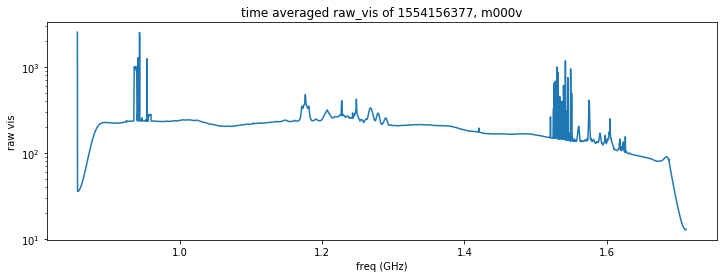

In [18]:
##time mean raw vis to show the bandpass
plt.figure(figsize=(12,4))
plt.plot(freqs/1e9,np.mean(vis[nd_0,:],axis=0))
plt.xlabel('freq (GHz)')
plt.ylabel('raw vis')
plt.yscale('log')
plt.title('time averaged raw_vis of '+str(fname)+', '+str(recv))
plt.show()

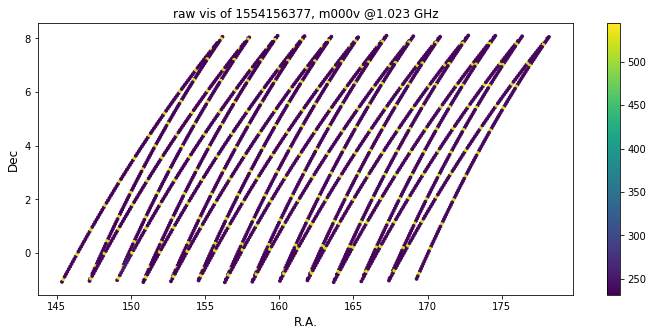

In [19]:
#raw vis map to check diode injection power and period
p_data=vis[dp_ss,ch_plot]
plt.figure(figsize=(12,5))
plt.scatter(ra[dp_ss],dec[dp_ss], c=p_data, vmin=np.min(p_data),vmax=np.max(p_data), s=8)
plt.colorbar()
plt.title('raw vis of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
#plt.savefig(str(fname)+'_'+str(recv1)+'_map_scan.pdf')
plt.show()

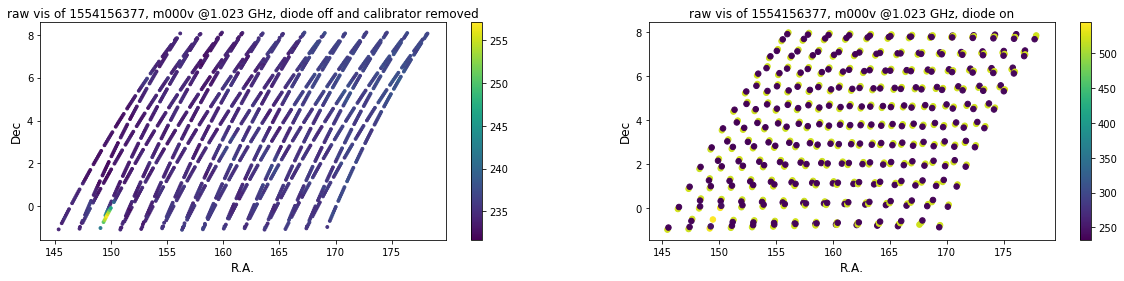

In [20]:
#diode off and diode on parts for above plot
plt.figure(figsize=(20,4))
plt.subplot(121)
p_data=vis[nd_s0,ch_plot]
plt.scatter(ra[nd_s0],dec[nd_s0], c=p_data, vmin=np.min(p_data),vmax=np.max(p_data), s=8)
plt.title('raw vis of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, diode off and calibrator removed',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.colorbar()
plt.subplot(122)
p_data=vis[nd_s1,ch_plot]
plt.scatter(ra[nd_s1],dec[nd_s1], c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=30)
plt.title('raw vis of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, diode on',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.colorbar()
plt.show()

<type 'numpy.ndarray'>


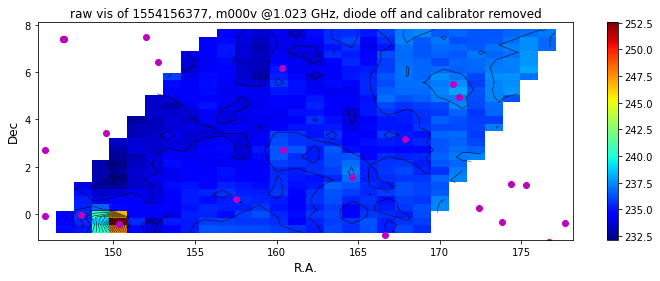

In [21]:
#interpolation map to show the raw vis data vis point sources (magenta dots)
p_data=vis[nd_s0,ch_plot]
plt.figure(figsize=(12,4))
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data)
plt.title('raw vis of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, diode off and calibrator removed',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.show()

# RFI flagging

## Basic RFI flagging (all channels)

In [22]:
#set the thresholds for SEEK 
First_Thresholds= [30, 60, 35, 70]

In [23]:
#rfi flagging for raw vis data
vis_clean=kr.vis_flag(vis_backup,flags,nd_label0, dp_w, First_Thresholds)

group shape (no flags):
286 286 572 2217 84 84 168 668
### load flags ###
data.flags ratio:
0.0666910915481
###mask data not track/scan###
---------------------------------------------------
###SEEK flagging###
First_Threshold_0, First_Threshold_1, First_Threshold_00, First_Threshold_11= [30, 60, 35, 70]
#flagging scan and nd_0
Std of the non-masked elements of tod is 56.4
Std/Mean of the non-masked elements of tod is 0.32
#flagging scan and nd_1a
Std of the non-masked elements of tod is 125.99
Std/Mean of the non-masked elements of tod is 0.31
#flagging scan and nd_1b
Std of the non-masked elements of tod is 57.33
Std/Mean of the non-masked elements of tod is 0.31
#flagging track and nd_0
Std of the non-masked elements of tod is 55.57
Std/Mean of the non-masked elements of tod is 0.27
#flagging track and nd_1a
Std of the non-masked elements of tod is 132.28
Std/Mean of the non-masked elements of tod is 0.31
#flagging track and nd_1b
Std of the non-masked elements of tod is 66.53
Std/M

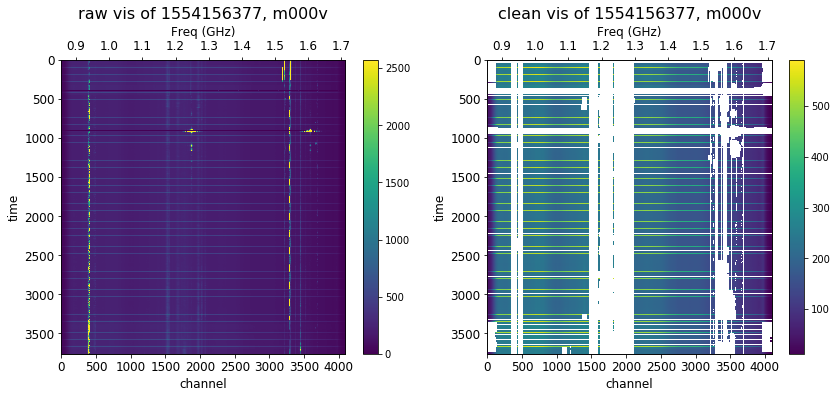

In [24]:
#compare vis before and after rfi flagging

plt.figure(figsize=(14,5.4))
plt.subplot(121)
plt.imshow(vis_backup,aspect='auto')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('time',fontsize=12)
plt.xlabel('channel',fontsize=12)
plt.title('raw vis of '+str(fname)+', '+str(recv),fontsize=16, y=1.12)
plt.colorbar()
plt.twiny()
plt.xticks(fontsize=12)
plt.imshow(vis_backup,aspect='auto',extent=(data.freqs[0]/1e9,data.freqs[-1]/1e9,len(timestamps),0))
plt.xlabel('Freq (GHz)',fontsize=12)
plt.subplot(122)
plt.imshow(vis_clean,aspect='auto')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('time',fontsize=12)
plt.xlabel('channel',fontsize=12)
plt.title('clean vis of '+str(fname)+', '+str(recv),fontsize=16, y=1.12)
plt.colorbar()
plt.twiny()
plt.xticks(fontsize=12)
plt.imshow(vis_clean,aspect='auto',extent=(data.freqs[0]/1e9,data.freqs[-1]/1e9,len(timestamps),0))
plt.xlabel('Freq (GHz)',fontsize=12)
#plt.savefig(str(fname)+'raw_vis.pdf')
#plt.savefig('test2.pdf')
plt.show()

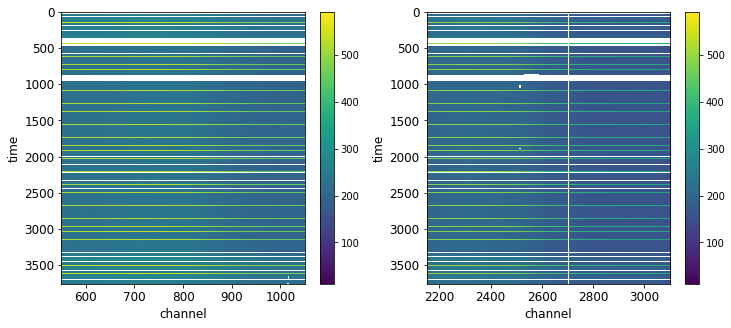

In [25]:
#####to show the part we are intrested (rfi 'free')####
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(vis_clean,aspect='auto')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('time',fontsize=12)
plt.xlabel('channel',fontsize=12)
plt.xlim(550,1050)
plt.colorbar()
plt.subplot(122)
plt.imshow(vis_clean,aspect='auto')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('time',fontsize=12)
plt.xlabel('channel',fontsize=12)
plt.xlim(2150,3100)
plt.colorbar()
plt.show()

In [26]:
vis_clean_old=vis_clean.copy() ###backup


<class 'numpy.ma.core.MaskedArray'>


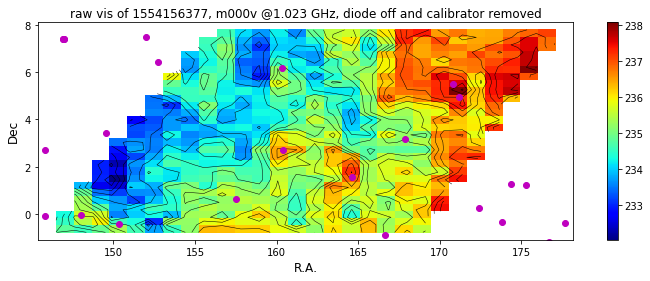

In [27]:
#interpolation map to show the raw vis data vis point sources (magenta dots)
p_data=vis_clean[nd_s0,ch_plot]
plt.figure(figsize=(12,4))
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data)
plt.title('raw vis of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, diode off and calibrator removed',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.show()

<class 'numpy.ma.core.MaskedArray'>


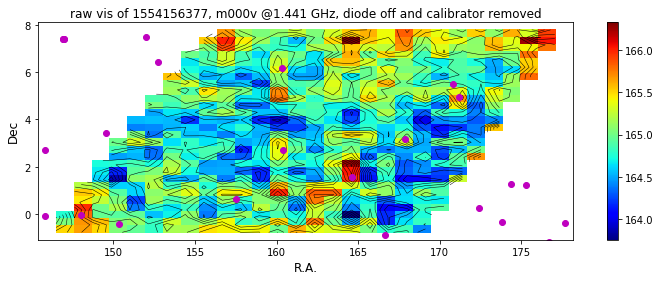

In [28]:
ch_plot1=2800
#interpolation map to show the raw vis data vis point sources (magenta dots)
p_data=vis_clean[nd_s0,ch_plot1]
plt.figure(figsize=(12,4))
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data)
plt.title('raw vis of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot1]/1e9,3)) +' GHz, diode off and calibrator removed',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.show()

# Multi Channels Calibration 

In [29]:
####prepare for data storage#################
cali_T=np.ma.array(np.zeros_like(vis),mask=True)
Tresi=np.ma.array(np.zeros_like(vis),mask=True)
Tnd_cal=[None for i in range(len(freqs))]
gt_param=[None for i in range(len(freqs))]
nd_s0_list=[None for i in range(len(freqs))]
eta_p_list=[None for i in range(len(freqs))]
ratio_list=[None for i in range(len(freqs))]
sm_param=[None for i in range(len(freqs))]
d={}

In [30]:
####prepare data for multi-band calibration####
#beam
beam_select='me'
Npix=513
Ddeg=5
pattern_fband=kb.load_pattern_fband(beam_select,pol)
Aeff_max_fband=kb.load_Aeff_max_fband(beam_select,pol)
x_pix,y_pix=kb.cal_pix_params(data,c0,Npix,Ddeg)
#Galactic model
nside=64 #healpix nside, 64: Mean Spacing (deg) is 0.9161
gal=km.cal_Gal_model_np(vis, freqs, ra, dec, 0, len(freqs), nside)
#Spill
Tspill_func=km.cal_Tspill_func(el,pol,freqs)
#diode noise
Tnd_std,Tnd_spl=km.Tnd_spl(data, ant,pol)
print Tnd_std


/users/jywang/MeerKAT/model_test/beam_model/eidos_sim/p513_d5_ch4096/primary_beam_me_p513_ch4096_d5_VV.fits
(3761,) (3761,)
256.0 256.0
l.4028 h
l.4028 v
1.33812408037


In [31]:
##set channels #full band is range(550,1051) + range(2150,3101):
for ch_plot in [600, 601, 800, 801, 1000, 1001, 2200, 2201, 2400, 2401, 2600, 2601, 2800, 2801, 3000, 3001]:
    print ch_plot
    check_ratio=float(np.array(vis_clean.mask[:,ch_plot]==False).sum())/len(timestamps)
    print check_ratio
    if check_ratio>0.6:
        ################reset param which related to chs ################
        dp_tt,dp_ss,dp_f,dp_t,dp_s=kl.label_dump_1ch(data,ant,pol,flags,ch_plot)
        dp_sb=dp_ss[0]
        dp_se=dp_ss[-1]
        #mark,nd_1,nd_1a,nd_1b,lmin,lmax=kd.label_nd_injection(fname,vis, timestamps, dp_ss, data.dump_period)
        nd_1a,nd_1b,nd_1,nd_0=kd.call_nd_1_list(fname,timestamps)
        nd_s1a,nd_s1b,nd_s1,nd_s0=kd.cal_nds_list(dp_ss,nd_1a,nd_1b,nd_1,nd_0)
        nd_t1a,nd_t1b,nd_t1,nd_t0=kd.cal_ndt_list(dp_tt,nd_1a,nd_1b,nd_1,nd_0)
        nd_labels=nd_s1a,nd_s1b,nd_s1,nd_s0,nd_t1a,nd_t1b,nd_t1,nd_t0
        dp_u=kl.cal_dp_u(dp_tt,dp_ss)
        ################################################################

        ###aplly the flagging
        vis_clean,nd_s0_clean=kr.vis_flag_1ch(vis_clean,nd_labels,ch_plot)
        #spill model 
        Tspill=Tspill_func((el,freqs[ch_plot]/1e6))[:,0]
        #atmosphere emission model
        Tatmo=km.calc_atmosphere_model_1ch(data,ch_plot)
        #elevation related emission model
        Tel=Tspill+Tatmo 
        #load the diode injection model and get a reference value
        Tnd_ref=Tnd_spl(freqs[ch_plot]/1e9)
        
        #BM-III:pattern
        #check pointing stable for track part
        if fname in ['1551055211','1551037708']:
            dp_ca,dp_cb,dp_c0a, dp_c1a,dp_c2a,dp_c3a,dp_c4a,dp_c0b,dp_c1b,dp_c2b,dp_c3b,dp_c4b=kl.cal_dp_c(fname,data,ant,pol,flags,ch_plot,dp_tt,dp_ss,ang_deg)
        else:
            dp_ca,dp_cb,dp_c0a, dp_c1a,dp_c0b,dp_c1b=kl.cal_dp_c(fname,data,ant,pol,flags,ch_plot,dp_tt,dp_ss,ang_deg)

        #calculate position
        T_ptr2,pattern,x_pix_max,y_pix_max=kb.cal_BMIII_1ch(data,ch_plot,flux_model, dp_ca,dp_cb,pattern_fband,x_pix,y_pix,Aeff_max_fband)
        
        #####choose beam model
        T_ptr=T_ptr2 #BM-III 
        #select raw vis for track befor scan
        visa_ptr = vis_clean.copy()
        for i in range(len(timestamps)):
            if i not in dp_ca:
                visa_ptr.mask[i,:]=True
        #show Tgal for track efor scan
        Tgal=gal[:,ch_plot]
        ####set input parameters
        ga0,gb0=ks.cal_gain0(fname,data,ant,pol,flags,ch_plot,dp_tt,dp_ss,ang_deg,T_ptr,vis_clean) #gain level
        Tsys0=10.
        eta_p0=1.0
        func_sm_param0=[Tsys0]
        func_gt_param0=[ga0,0,0,0,0]
        ratio0=0.5
        ####fitting
        instru_pa=ks.solve_params0(timestamps, visa_ptr, ch_plot, nd_ratio, ratio0, T_ptr, eta_p0, Tnd_ref, Tnd_std, Tel, Tgal,
                              func_gt_param0, func_sm_param0, nd_0, nd_1a, nd_1b)
        ####get fitting result
        Tnda=instru_pa[0]
        eta_pa=instru_pa[1]
        sma=instru_pa[2]
        gta=instru_pa[3:-1]
        ratioa=instru_pa[-1]
        print Tnda, eta_pa, ratioa , sma, gta
        #select raw vis for track befor scan
        visb_ptr = vis_clean.copy()
        for i in range(len(timestamps)):
            if i not in dp_cb:
                visb_ptr.mask[i,:]=True
        ####set input parameters
        Tsys0=10.
        eta_p0=1.0
        func_sm_param0=[Tsys0]
        func_gt_param0=[gb0,0,0,0,0]
        ratio0=0.5
        ####fitting######
        instru_pb=ks.solve_params0(timestamps, visb_ptr, ch_plot, nd_ratio, ratio0, T_ptr, eta_p0, Tnd_ref, Tnd_std, Tel, Tgal,
                              func_gt_param0, func_sm_param0, nd_0, nd_1a, nd_1b)
        ######get fitting result#####
        Tndb=instru_pb[0]
        eta_pb=instru_pb[1]
        smb=instru_pb[2]
        gtb=instru_pb[3:-1]
        ratiob=instru_pb[-1]
        print Tndb, eta_pb, ratiob , smb, gtb
        ###set input params
        Tnd=(Tnda+Tndb)/2.
        g0=(ga0+gb0)/2.
        Tptr=0 #no point source
        Tsys0=10.
        eta_p0=1.0
        func_sm_param0=[Tsys0,0,0,0]
        func_gt_param0=[g0,0,0,0,0]#must be [-6:-1] from func_obj_sm
        ratio0=0.5
        print Tnd,Tnda,Tndb
        ###raw vis preparsion
        vis_clean_tt=vis_clean.copy()
        vis_clean_tt.mask[:dp_sb,:]=True
        vis_clean_tt.mask[dp_se+1:,:]=True
        ##fitting
        instru_p=ks.solve_params_sm(timestamps, vis_clean_tt, ch_plot, nd_ratio, ratio0, Tptr, eta_p0, Tnd, Tel, Tgal,
                              func_gt_param0, func_sm_param0, nd_0, nd_1a, nd_1b)
        ###output
        eta_p=instru_p[0]
        sm=instru_p[1:-6]
        gt=instru_p[-6:-1] #must be [-5:-1] from func_obj_sm
        ratio=instru_p[-1]
        print eta_p, ratio, sm, gt
        m=ks.calc_total_model_sm(timestamps, nd_ratio, ratio, Tptr, eta_p, Tnd, Tel, Tgal,  gt, sm, nd_0, nd_1a, nd_1b)
        #residual curve
        residual=(vis_clean[:,ch_plot]-m)/ks.func_gt(timestamps,gt)
        print 'resi: '+str(np.mean(residual[nd_s0]))+', '+str(np.std(residual[nd_s0]))
        T=vis_clean[:,ch_plot]/ks.func_gt(timestamps,gt)
        #############save data##################
        cali_T[nd_s0,ch_plot]=T[nd_s0]
        Tresi[nd_s0,ch_plot]=residual[nd_s0]
        Tnd_cal[ch_plot]=[Tnda,Tndb]
        gt_param[ch_plot]=gt
        nd_s0_list[ch_plot]=nd_s0
        #---
        eta_p_list[ch_plot]=[eta_pa,eta_pb]
        ratio_list[ch_plot]=[ratioa,ratiob,ratio]
        sm_param[ch_plot]=sm
        ###
        if ch_plot % 10 == 0:
            d['cali_T']=cali_T
            d['Tresidual']=Tresi
            d['Tnd_cal']=Tnd_cal
            d['gt_param']=gt_param
            d['nd_s0_list']=nd_s0_list
            #---
            d['eta_p_list']=eta_p_list
            d['ratio_list']=ratio_list
            d['sm_param']=sm_param
            fs=open(str(fname)+'_'+str(recv)+'_cali_notedata','wb')
            pickle.dump(d,fs,protocol=2)
            fs.close()
            print '*data saved at ch '+str(ch_plot)
    else:
        print "***good data ratio is low!"

600
0.897633608083


group shape (with flags):
285 283 568 2184 79 79 158 628
iter=0
deg filter start: 0.700865972442+/-0.0178962280775
deg filter end: 0.70000410731+/-0.000243852549685

deg filter start: 0.000369660982059+/-0.000288915798119
deg filter end: 0.000369660982059+/-0.000288915798119

128.471737609
(array([255]), array([256]))
255 256
alpha=0.21892182564
deg filter start: 0.700865972442+/-0.0178962280775
deg filter end: 0.70000410731+/-0.000243852549685

deg filter start: 0.000369660982059+/-0.000288915798119
deg filter end: 0.000369660982059+/-0.000288915798119

Optimization terminated successfully.
         Current function value: 170.248986
         Iterations: 45
         Function evaluations: 11315
17.9672535031 1.0 0.900589772506 4.22738505711 [ 17.78649904  -6.15016258 -13.59688685 -10.69686146  -2.9843478 ]
Optimization terminated successfully.
         Current function value: 261.751869
         Iterations: 43
         Function evaluations: 10741
19.4731659695 1.0 0.900202412804 5.7247

# save data

In [32]:
####save data####
d['cali_T']=cali_T
d['Tresidual']=Tresi
d['Tnd_cal']=Tnd_cal
d['gt_param']=gt_param
d['nd_s0_list']=nd_s0_list
d['eta_p_list']=eta_p_list
d['ratio_list']=ratio_list
d['sm_param']=sm_param
fs=open(str(fname)+'_'+str(recv)+'_cali_notedata','wb')
pickle.dump(d,fs,protocol=2)
fs.close()


In [33]:
d.keys()

['Tnd_cal',
 'sm_param',
 'ratio_list',
 'Tresidual',
 'cali_T',
 'eta_p_list',
 'nd_s0_list',
 'gt_param']

# Some plots

In [34]:
print fname,recv

1554156377 m000v


In [35]:
#load full band result calulated by katcali_multi.py  
#d=pickle.load(open(str(fname)+'_'+str(recv)+'_cali_data'))

#load several channel result calulated by this notebook  
d=pickle.load(open(str(fname)+'_'+str(recv)+'_cali_notedata'))

In [36]:
d.keys()

['Tresidual',
 'sm_param',
 'ratio_list',
 'Tnd_cal',
 'cali_T',
 'eta_p_list',
 'nd_s0_list',
 'gt_param']

In [37]:
#load data in
Tresidual=d['Tresidual']
Tnd_cal=d['Tnd_cal']
cali_T=d['cali_T']
nd_s0_list=d['nd_s0_list']
gt_param=d['gt_param']
eta_p_list=d['eta_p_list']
ratio_list=d['ratio_list']
sm_param=d['sm_param']

#cal_Tnd is for single channel only! Tnd_spl has higher efficiency for multi channel calibration
l.4028 h
l.4028 v
1.33812408037


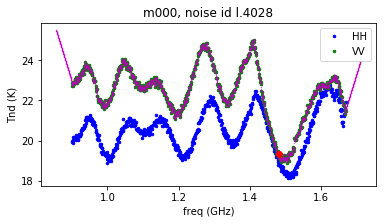

In [38]:
Tnd_std,Tnd_ref,noise,Tnd_spl= km.call_Tnd(data, ant, pol,freqs,ch_plot,1)

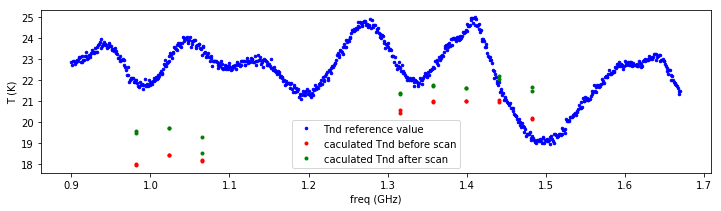

In [39]:
plt.figure(figsize=(12,3))
plt.plot(noise[pol][:,0]/1e9,noise[pol][:,1],'b.', ms=5)
for i in range(len(freqs)):
    if Tnd_cal[i] is not None and i<3100:
        plt.plot(freqs[i]/1e9,Tnd_cal[i][0],'r.')
        plt.plot(freqs[i]/1e9,Tnd_cal[i][1],'g.')
plt.xlabel('freq (GHz)')
plt.ylabel('T (K)')
plt.legend(['Tnd reference value', 'caculated Tnd before scan', 'caculated Tnd after scan'])
plt.show()

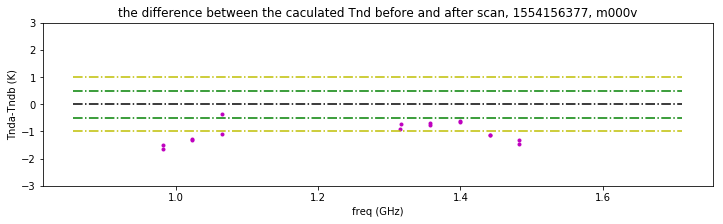

In [40]:
a=[]
plt.figure(figsize=(12,3))
for i in range(len(freqs)):
    if Tnd_cal[i] is not None and i<3100:
        plt.plot(freqs[i]/1e9,Tnd_cal[i][0]-Tnd_cal[i][1],'m.')
        a.append(Tnd_cal[i][0]-Tnd_cal[i][1])
plt.ylim(-3,3)
plt.plot([freqs[0]/1e9,freqs[-1]/1e9],[0,0],'k-.')
plt.plot([freqs[0]/1e9,freqs[-1]/1e9],[1,1],'y-.')
plt.plot([freqs[0]/1e9,freqs[-1]/1e9],[0.5,0.5],'g-.')
plt.plot([freqs[0]/1e9,freqs[-1]/1e9],[-0.5,-0.5],'g-.')
plt.plot([freqs[0]/1e9,freqs[-1]/1e9],[-1,-1],'y-.')
plt.xlabel('freq (GHz)')
plt.ylabel('Tnda-Tndb (K)')
plt.title('the difference between the caculated Tnd before and after scan, '+str(fname)+', '+str(recv))
plt.show()


In [41]:
ch1=800
ch2=ch1+1

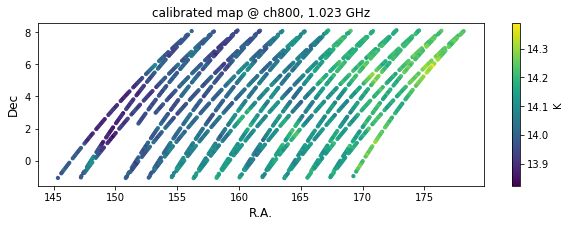

In [42]:
plt.figure(figsize=(10,3))
p_data=cali_T[:,ch1]
plt.scatter(ra, dec , c=p_data ,s=10)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.title('calibrated map @ ch'+str(ch1)+', '+str(round(freqs[ch1]/1e9,3))+' GHz')
plt.colorbar(label='K')
plt.show()

<class 'numpy.ma.core.MaskedArray'>


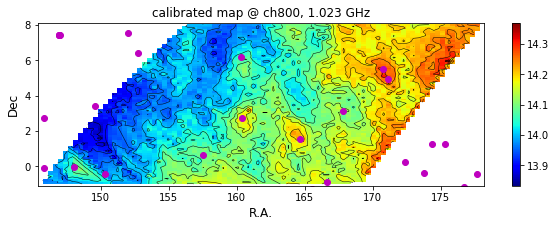

In [43]:
plt.figure(figsize=(10,3))
p_data=cali_T[:,ch1]
kv.plot_data(ra,dec, p_data,gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.title('calibrated map @ ch'+str(ch1)+', '+str(round(freqs[ch1]/1e9,3))+' GHz')
plt.show()

<class 'numpy.ma.core.MaskedArray'>


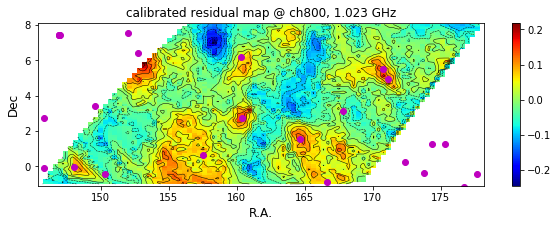

In [44]:
plt.figure(figsize=(10,3))
p_data=Tresidual[:,ch1]
kv.plot_data(ra,dec, p_data,gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.title('calibrated residual map @ ch'+str(ch1)+', '+str(round(freqs[ch1]/1e9,3))+' GHz')
plt.show()

In [45]:
rms_thero= cali_T[:,ch1].mean()*np.sqrt(2)/np.sqrt(data.dump_period*(freqs[ch2]-freqs[ch1]))
print rms_thero

0.0308211238258


1.17632710207e-05 0.031042689591
<class 'numpy.ma.core.MaskedArray'>


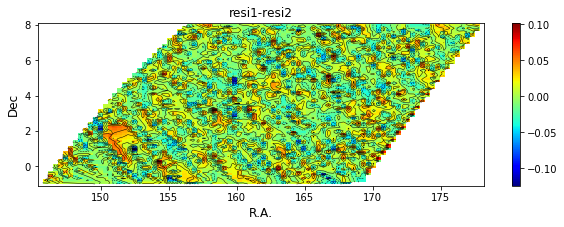

In [46]:
plt.figure(figsize=(10,3))
p_data=Tresidual[:,ch1]-Tresidual[:,ch2]
print p_data.mean(),p_data.std()
if p_data.std() is not np.NaN:
    kv.plot_data(ra,dec, p_data,gsize=plot_gsize)
#plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.title('resi1-resi2')
plt.show()

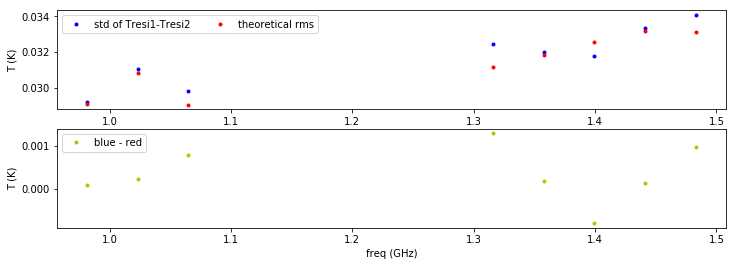

In [47]:
#comparison between "std of residual difference" and "theoretical rms"
plt.figure(figsize=(12,4))
plt.subplot(211)
for i in range(len(freqs)):
    ch1=i
    ch2=i+1
    if ((Tresidual[:,ch1].mask==True).all()==False 
    and (Tresidual[:,ch2].mask==True).all()==False 
    and ch2<=3100):
        p_data=Tresidual[:,ch1]-Tresidual[:,ch2]
        std=p_data.std()
        rms_thero=cali_T[:,ch1].mean()*np.sqrt(2)/np.sqrt(data.dump_period*(freqs[ch2]-freqs[ch1]))
        plt.plot(freqs[ch1]/1e9,p_data.std(),'b.')
        plt.plot(freqs[ch1]/1e9,rms_thero,'r.')
plt.legend(['std of Tresi1-Tresi2', 'theoretical rms'],ncol=2)
#plt.xlabel('freq (GHz)')
plt.ylabel('T (K)')
#plt.show()
plt.subplot(212)
for i in range(len(freqs)):
    ch1=i
    ch2=i+1
    if ((Tresidual[:,ch1].mask==True).all()==False 
    and (Tresidual[:,ch2].mask==True).all()==False 
    and ch2<=3100):
        p_data=Tresidual[:,ch1]-Tresidual[:,ch2]
        std=p_data.std()
        rms_thero=cali_T[:,ch1].mean()*np.sqrt(2)/np.sqrt(data.dump_period*(freqs[ch2]-freqs[ch1]))
        plt.plot(freqs[ch1]/1e9,p_data.std()-rms_thero,'y.')
plt.legend(['blue - red'])
plt.xlabel('freq (GHz)')
plt.ylabel('T (K)')
plt.show()

In [48]:
t2=time.time()
print t2-t1

1658.75822401


In [49]:
print 'end @ ' + time.asctime(time.localtime(time.time())) +'#'

end @ Sun Mar  1 17:27:34 2020#
